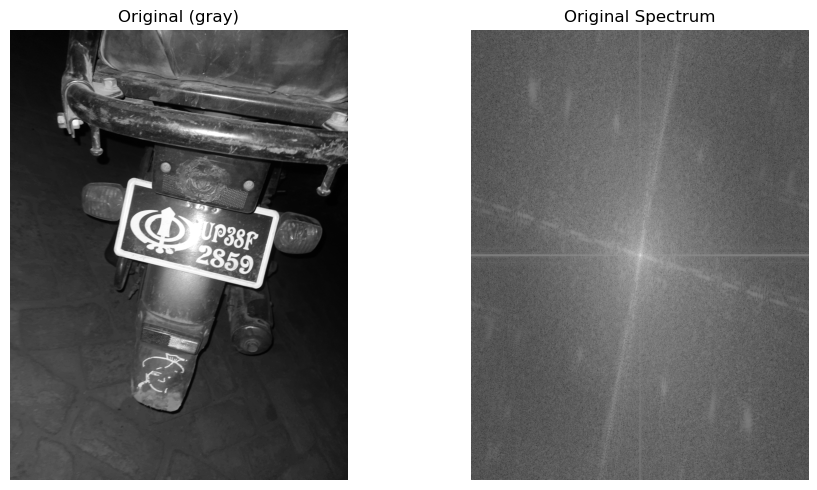

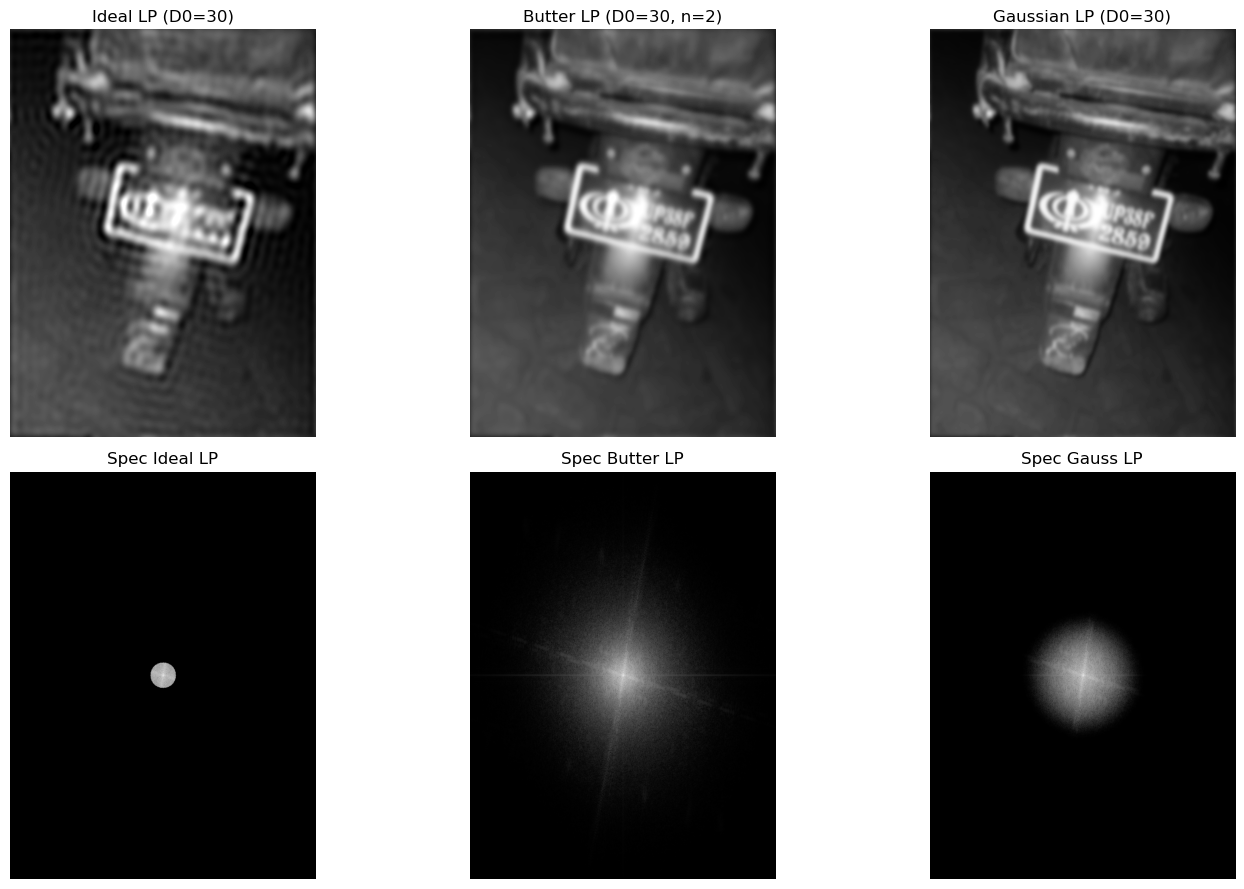

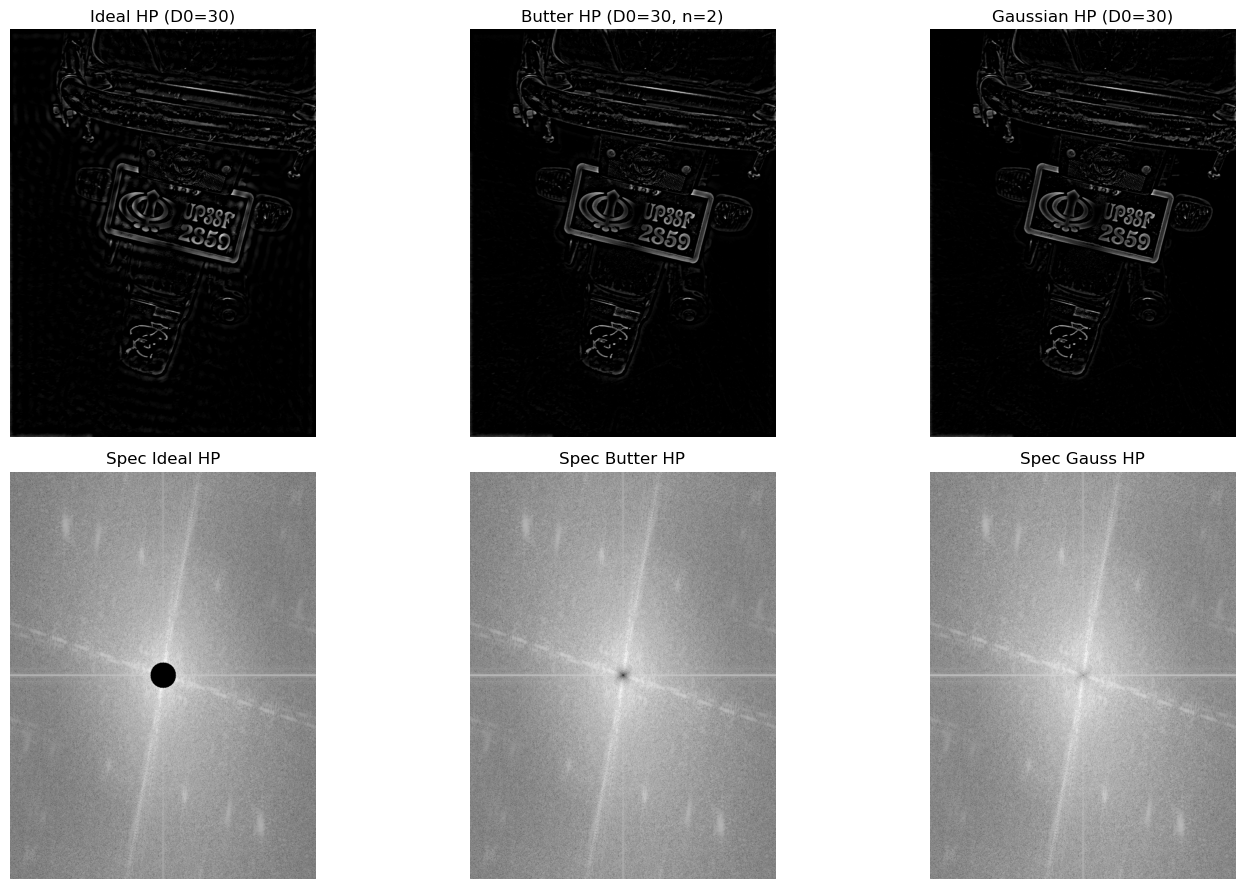

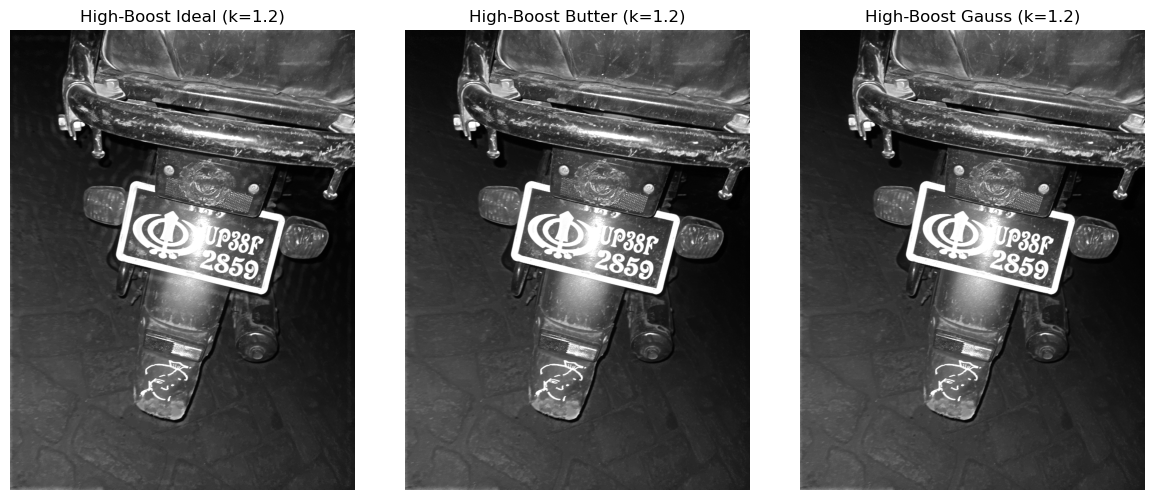

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = r"E:\Indian_Number_Plates\Sample_Images\Datacluster_number_plates (55).jpg"

def show_grid(titles, imgs, max_cols=4, figsize=(15,11), cmap='gray'):
    n = len(imgs); cols = min(max_cols, n); rows = (n+cols-1)//cols
    plt.figure(figsize=figsize)
    for i,(t,img) in enumerate(zip(titles, imgs), 1):
        plt.subplot(rows, cols, i)
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img); plt.title(t); plt.axis('off'); continue
        plt.imshow(img, cmap=cmap); plt.title(t); plt.axis('off')
    plt.tight_layout(); plt.show()

def load_gray_resized(path):
    bgr = cv2.imread(path)
    if bgr is None: raise FileNotFoundError(path)
    h,w = bgr.shape[:2]
    scale = 720.0/min(h,w); scale = min(1.0, scale)
    bgr = cv2.resize(bgr, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# ---------- Frequency helpers ----------
def dft2(img):
    f = np.fft.fft2(img.astype(np.float32))
    fshift = np.fft.fftshift(f)
    return fshift

def idft2(fshift):
    ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(ishift)
    img_back = np.real(img_back)
    img_back = np.clip(img_back, 0, 255).astype(np.uint8)
    return img_back

def spectrum_log(fshift):
    mag = np.abs(fshift)
    mag = np.log1p(mag)
    mag = (255*(mag - mag.min())/(mag.max()-mag.min()+1e-12)).astype(np.uint8)
    return mag

def radius_grid(shape):
    rows, cols = shape
    u = np.arange(rows) - rows//2
    v = np.arange(cols) - cols//2
    V,U = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    return D

# ---------- Filters ----------
def ideal_lpf(shape, D0):
    D = radius_grid(shape)
    H = np.zeros(shape, np.float32)
    H[D <= D0] = 1.0
    return H

def butterworth_lpf(shape, D0, n=2):
    D = radius_grid(shape)
    H = 1.0 / (1.0 + (D / (D0+1e-12))**(2*n))
    return H.astype(np.float32)

def gaussian_lpf(shape, D0):
    D = radius_grid(shape)
    H = np.exp(-(D**2) / (2*(D0**2)+1e-12))
    return H.astype(np.float32)

def ideal_hpf(shape, D0):
    return 1.0 - ideal_lpf(shape, D0)

def butterworth_hpf(shape, D0, n=2):
    return 1.0 - butterworth_lpf(shape, D0, n)

def gaussian_hpf(shape, D0):
    return 1.0 - gaussian_lpf(shape, D0)

# High-boost (optional): H_boost = 1 + k*HPF
def highboost(mask_hpf, k=1.0):
    return 1.0 + k*mask_hpf

def apply_filter(img_gray, H):
    fshift = dft2(img_gray)
    G = fshift * H
    out = idft2(G)
    return out, spectrum_log(G)

def main():
    gray = load_gray_resized(IMG_PATH)
    fshift = dft2(gray)
    spec0 = spectrum_log(fshift)

    rows, cols = gray.shape
    D0 = 30                      # cutoff radius in frequency (tune 10–80)
    order = 2                    # Butterworth order
    k_boost = 1.2                # high-boost factor (optional sharpening)

    # ---- Smoothing (Low-pass) ----
    H_ideal_lp = ideal_lpf((rows, cols), D0)
    H_butt_lp  = butterworth_lpf((rows, cols), D0, n=order)
    H_gauss_lp = gaussian_lpf((rows, cols), D0)

    lp_ideal, spec_lp_ideal = apply_filter(gray, H_ideal_lp)
    lp_butt,  spec_lp_butt  = apply_filter(gray, H_butt_lp)
    lp_gauss, spec_lp_gauss = apply_filter(gray, H_gauss_lp)

    # ---- Sharpening (High-pass) ----
    H_ideal_hp = ideal_hpf((rows, cols), D0)
    H_butt_hp  = butterworth_hpf((rows, cols), D0, n=order)
    H_gauss_hp = gaussian_hpf((rows, cols), D0)

    hp_ideal, spec_hp_ideal = apply_filter(gray, H_ideal_hp)
    hp_butt,  spec_hp_butt  = apply_filter(gray, H_butt_hp)
    hp_gauss, spec_hp_gauss = apply_filter(gray, H_gauss_hp)

    # Optional high-boost versions (HPF added to original)
    hb_ideal = cv2.addWeighted(gray, 1.0, hp_ideal, k_boost, 0)
    hb_butt  = cv2.addWeighted(gray, 1.0, hp_butt,  k_boost, 0)
    hb_gauss = cv2.addWeighted(gray, 1.0, hp_gauss, k_boost, 0)

    # ---- Display ----
    show_grid(
        ["Original (gray)", "Original Spectrum"],
        [gray, spec0],
        max_cols=2, figsize=(10,5)
    )

    show_grid(
        [f"Ideal LP (D0={D0})", f"Butter LP (D0={D0}, n={order})", f"Gaussian LP (D0={D0})",
         "Spec Ideal LP", "Spec Butter LP", "Spec Gauss LP"],
        [lp_ideal, lp_butt, lp_gauss, spec_lp_ideal, spec_lp_butt, spec_lp_gauss],
        max_cols=3, figsize=(15,9)
    )

    show_grid(
        [f"Ideal HP (D0={D0})", f"Butter HP (D0={D0}, n={order})", f"Gaussian HP (D0={D0})",
         "Spec Ideal HP", "Spec Butter HP", "Spec Gauss HP"],
        [hp_ideal, hp_butt, hp_gauss, spec_hp_ideal, spec_hp_butt, spec_hp_gauss],
        max_cols=3, figsize=(15,9)
    )

    show_grid(
        [f"High-Boost Ideal (k={k_boost})", f"High-Boost Butter (k={k_boost})", f"High-Boost Gauss (k={k_boost})"],
        [hb_ideal, hb_butt, hb_gauss],
        max_cols=3, figsize=(12,5)
    )

if __name__ == "__main__":
    main()
